# Hourly clustering over whole year 2024

In [60]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation_kMeans
from Hyperparameters_KMeans import optimize_kmeans
import cluster_statistics_kMeans
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [61]:
dataset = "GroupE"    # Options: "SWW", "GroupE"
building_type = "house" # "flat", "house", "all"
number_of_clusters = 6

## Data Clustering

In [62]:
input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized")
#input_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_weekly_normalized/SM_DATA_weekly_normalized_6')


In [ ]:
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data_{dataset}.xlsx")

df = pd.read_excel(
    file_path,
    skiprows=4,
    nrows=1500,
    header=None,
    #dtype={10: str, 142: str},   # Spalte 10 (Resident_ID) und 142 als String
    dtype={0: str, 148: str},   # Spalte 10 (Resident_ID) und 142 als String
)
cols_to_extract = [0, 148]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['resident_id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_resident_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_resident_ids}")

if total_rows > unique_resident_ids:
    print(f"There are {total_rows - unique_resident_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

category_df = extracted_df.copy()
rows_to_keep_indices = []
exclude_building_type = building_type

if building_type == "all":
    exclude_building_type = None
elif building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

if building_type != "all":
    for i, row in category_df.iterrows():
        # Check if 'No Information' NOT in any value of that row
        if "No Information" not in row.values:
            # Check if 'Flat' NOT in any value of that row
            if exclude_building_type not in row.values:
                rows_to_keep_indices.append(i)
else:
    for i, row in category_df.iterrows():
        rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])
#category_df = category_df.drop(columns=['resident_id'])

category_df = category_df.iloc[rows_to_keep_indices]

Total rows: 378
Unique resident_id count: 378
No duplicates found in house_id column.


In [64]:
n_timestamps = 96

# Alle CSV-Dateien
pattern = str(input_folder / "*.csv")
file_paths = glob.glob(pattern)

data_list = []
filename_list = []

# gültige IDs aus category_df als Strings
valid_ids = set(category_df["resident_id"].astype(str))

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)        # z.B. "10030.csv"
    resid, _ = os.path.splitext(base)         # "10030"

    if resid not in valid_ids:
        continue

    if len(df) != n_timestamps:
        continue

    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

Shape of the 3D array: (212, 96, 1)


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

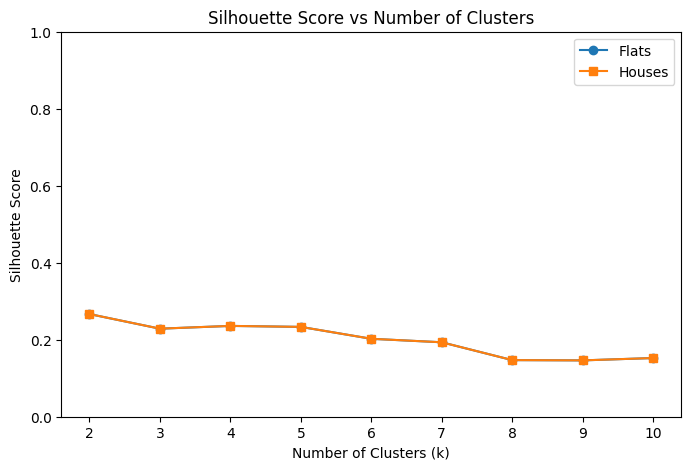

Minimum Silhouette Score Dataset 1: 0.266667763067225
Minimum Silhouette Score Dataset 2: 0.266667763067225
0.23589628776233354
1.4943793832519285


In [65]:
from importlib import reload
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import validation
from validation import validation_kMeans
reload(validation)
validation_kMeans(train_data, train_data, dataset)

#optimize_kmeans(train_data)

kmeans = TimeSeriesKMeans(n_clusters=4,max_iter=500, verbose=False, random_state=42,n_init=2, n_jobs=-1)
labels_clusters = kmeans.fit_predict(train_data.reshape((train_data.shape[0], train_data.shape[1])))
            
sh = silhouette_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)
db = davies_bouldin_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)

print(sh)
print(db)


# K-means Clustering
change n_clusters as required

In [66]:
max_iterations =200
n_init = 3

kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters, max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

# Plotting the cluster average patterns

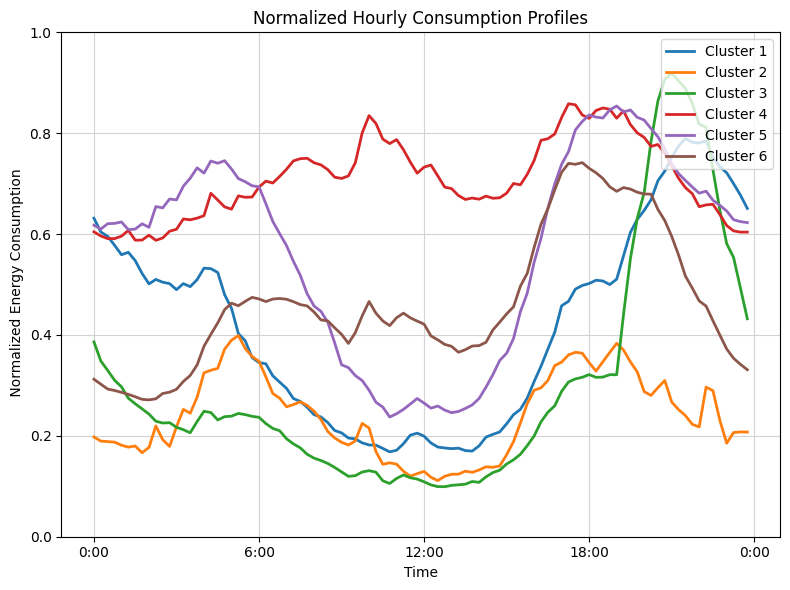

In [67]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_clusters = len(np.unique(clusters_train))

plt.figure(figsize=(8,6))
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    

    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    cluster_no = cluster_idx+1
    plt.plot(range(1,97), mean_time_series.ravel(), 
            label= f'Cluster {cluster_no}',
            linewidth =2, color=colors[cluster_idx] )
plt.title(f'Normalized Hourly Consumption Profiles')
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
plt.grid(True, color = 'lightgray')
plt.legend(
loc='upper right',
bbox_to_anchor=(1, 1),
ncol=1,
fontsize='medium'
)
plt.savefig(
f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/HourlyAveraged_KMeans_{building_type}.png",
bbox_inches='tight'
)
plt.show()

## Actual energy consumption of each cluster

In [68]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
resident_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "resident_id": resident_ids,
    "cluster": clusters_train + 1
}).sort("cluster")

result_df.write_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMeans_{building_type}.csv")




In [ ]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv")

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="resident_id",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = round(result_df["bruttolastgang_kwh_sum"].mean(),2)
overall_seasonal_avg = round(result_df['average_daily_consumption'].mean(),2)

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["resident_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "avg_daily_consumption [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (7, 4)
┌──────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---      ┆ ---            ┆ ---                          ┆ ---                         │
│ str      ┆ u32            ┆ f64                          ┆ f64                         │
╞══════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1        ┆ 36             ┆ 17209.1                      ┆ 71.98                       │
│ 2        ┆ 24             ┆ 10908.73                     ┆ 45.94                       │
│ 3        ┆ 46             ┆ 16622.7                      ┆ 70.24                       │
│ 4        ┆ 21             ┆ 14554.37                     ┆ 60.29                       │
│ 5        ┆ 42             ┆ 15351.86                     ┆ 64.11                       │
│ 6        ┆ 43             ┆ 12004.5                      ┆ 49.95          

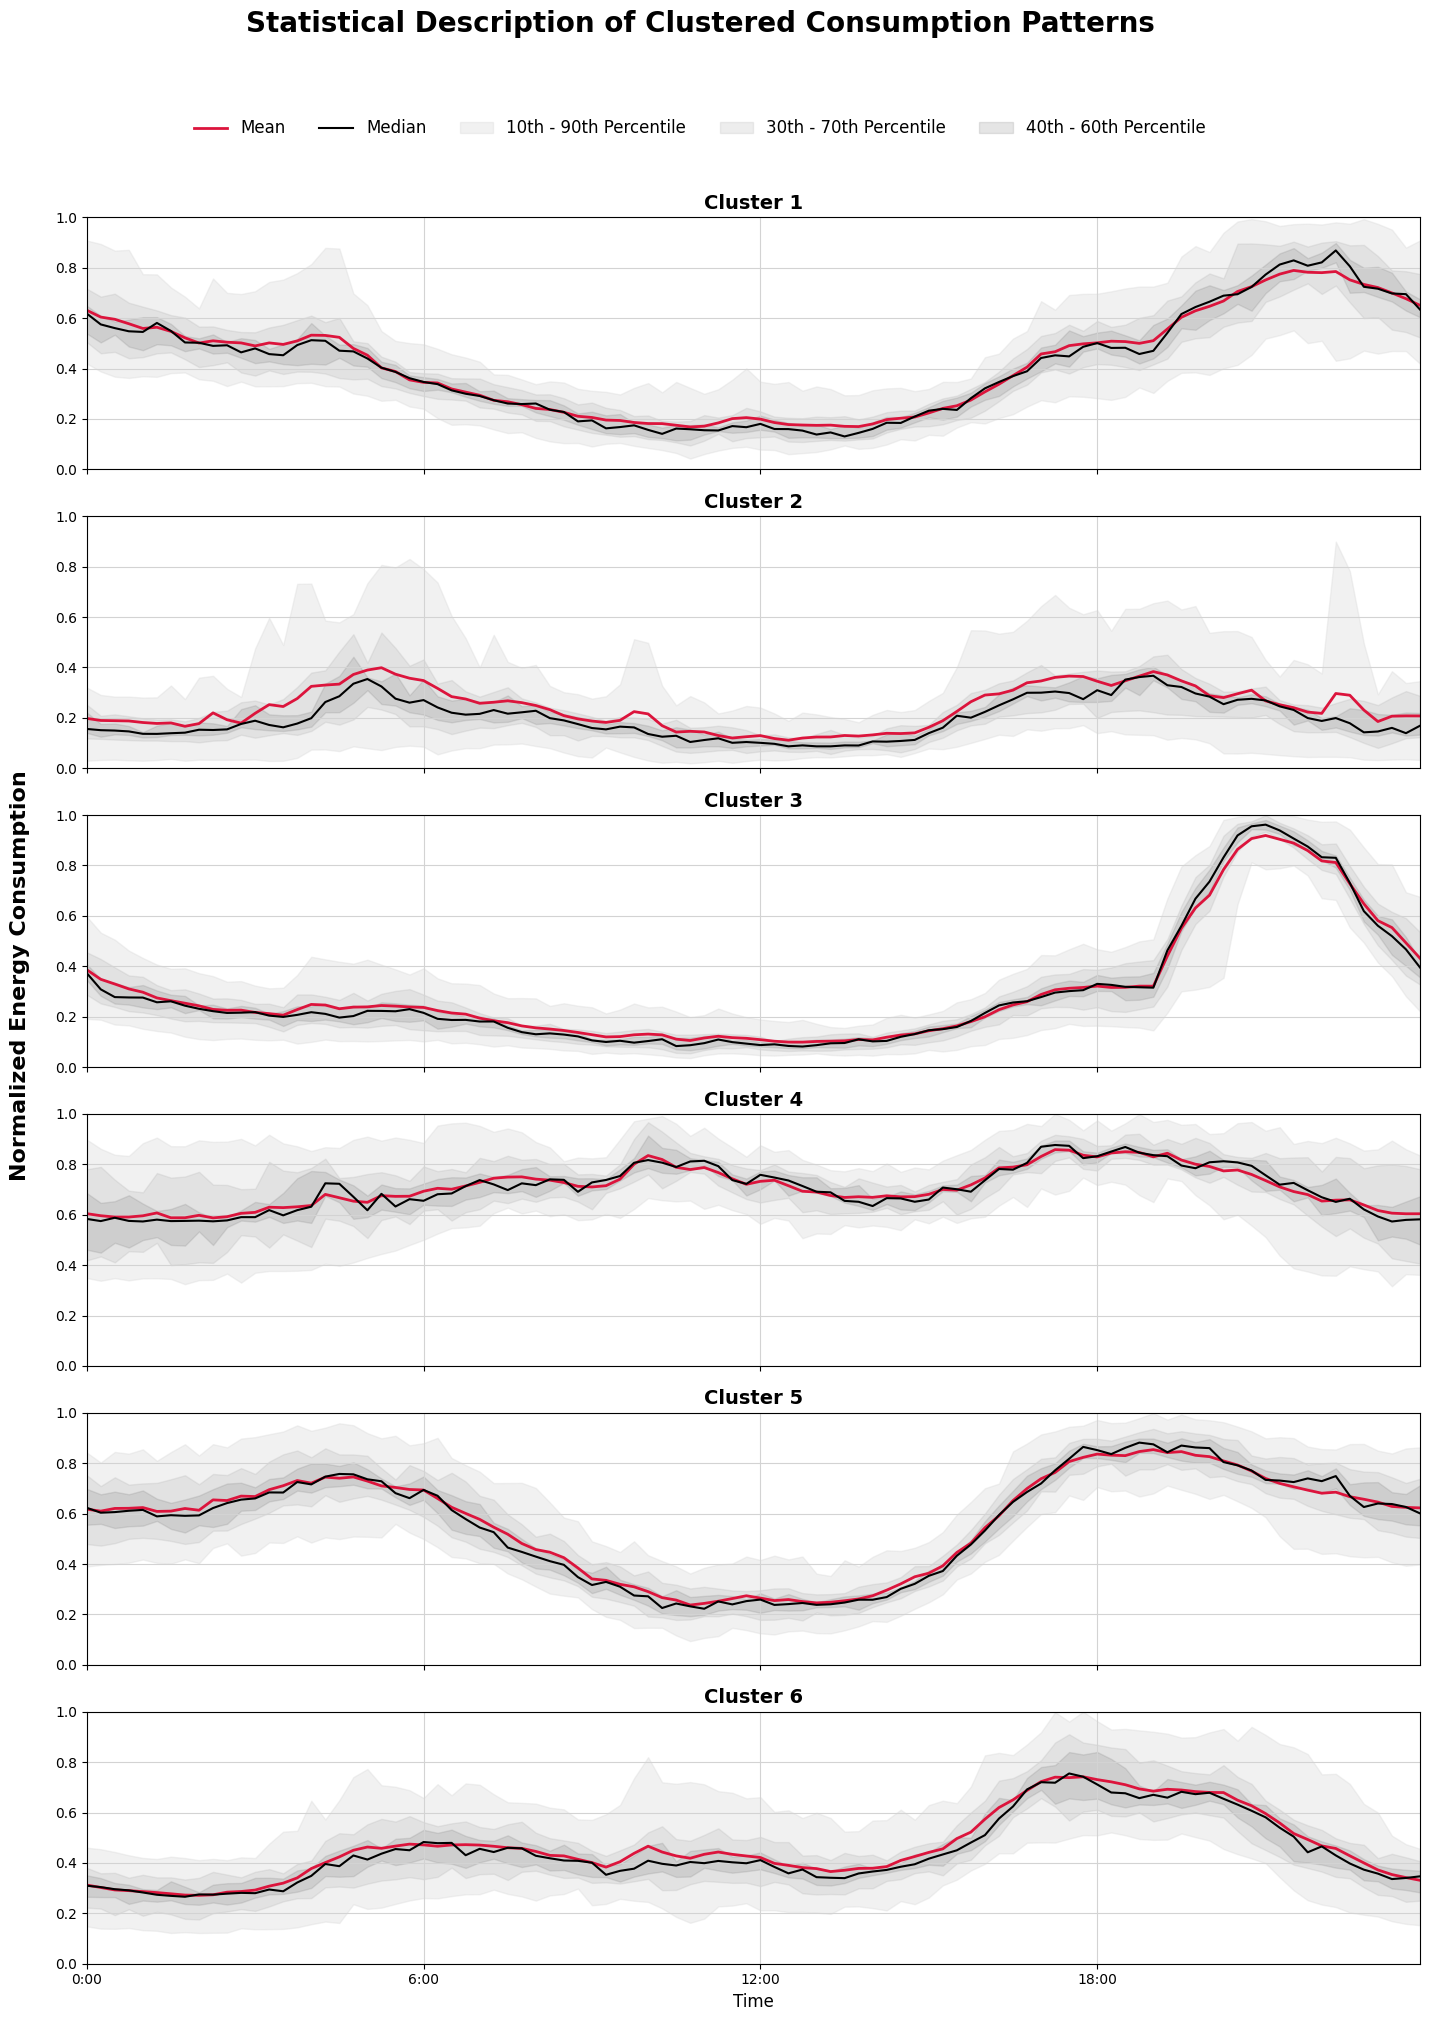

In [70]:
reload(cluster_statistics_kMeans)

from cluster_statistics_kMeans import plot_cluster_percentiles

#data_3d_kProt = np.expand_dims(train_data, axis=-1)

#print(data_3d_kProt.shape)

#print(data_3d_kProt)

clusters_train = clusters_train + 1  # Shift cluster labels to start from 1

for i in range(number_of_clusters):

    i = i+1
    # Select samples for the current cluster
    cluster_data = train_data[clusters_train == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue  # Skip this cluster

plot_cluster_percentiles(train_data,clusters_train,number_of_clusters, building_type, dataset)

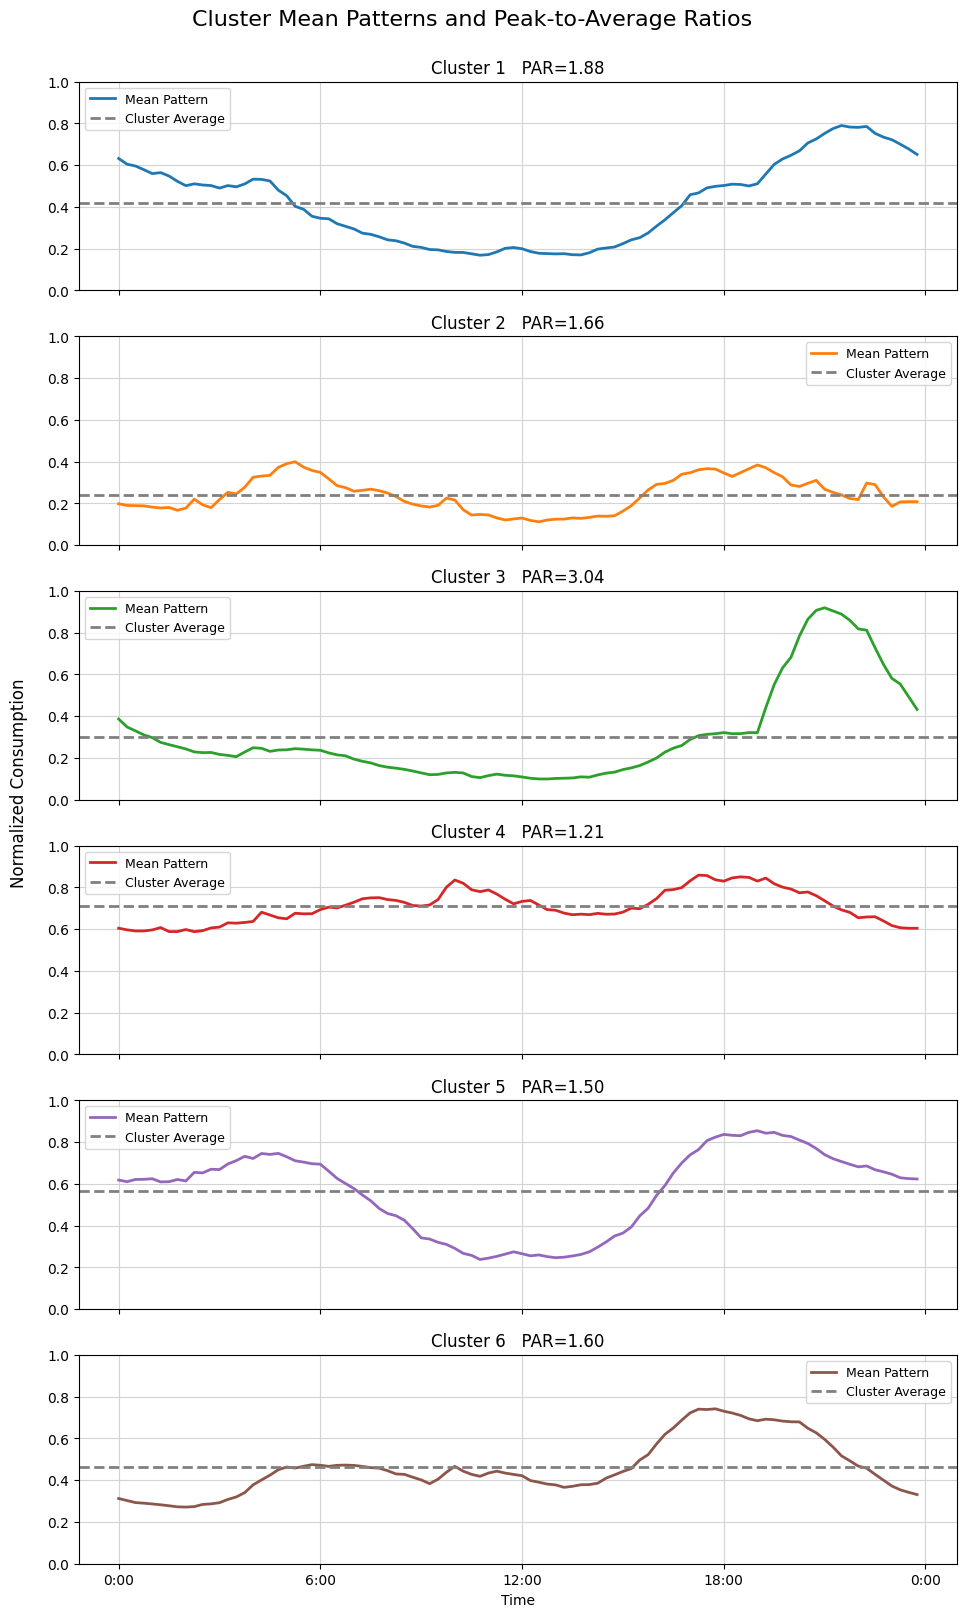

In [71]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


clusters = clusters_train  # Cluster labels starting from 1
time_series_numeric = train_data.reshape((train_data.shape[0], train_data.shape[1]))

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])  # Keine X-Ticks für die oberen Subplots
    # ACHTUNG: Kein ax.set_ylabel() hier!

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/PAR_KMeans_{building_type}.png",
    bbox_inches='tight'
)
plt.show()